# Compare with baseline

Our choice of GPR with wd kernel with shift
Baseline: GPR with RBF, onehot.

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *

import pickle
import xarray

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
Path = '../../data/firstRound_Microplate_normTrue_formatSeq_logTrue.csv'

df = pd.read_csv(Path)
df.head()

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,STD
0,0,RBS_1by1_0,reference,TTTAAGAAGGAGATATACAT,AGGAGA,1.616261,1.814182,1.760954,2.186207,2.028863,1.831982,1.881293,0.225819
1,1,RBS_1by1_1,bps_noncore,CTTAAGAAGGAGATATACAT,AGGAGA,1.166174,1.337018,1.417248,1.493800,1.713526,1.644568,1.425553,0.201725
2,2,RBS_1by1_2,bps_noncore,GTTAAGAAGGAGATATACAT,AGGAGA,0.604551,0.751384,0.851987,0.514929,0.577299,0.795227,0.660030,0.137994
3,3,RBS_1by1_3,bps_noncore,ATTAAGAAGGAGATATACAT,AGGAGA,1.221264,1.466278,1.270212,1.341040,1.395030,1.175433,1.338765,0.097386
4,4,RBS_1by1_4,bps_noncore,TCTAAGAAGGAGATATACAT,AGGAGA,1.160566,1.579025,1.171829,1.590670,1.411255,1.756862,1.382669,0.210012


In [3]:
run_kfold = False

if run_kfold:

    kernel = 'WD_Kernel_Shift'
    eva_metric = [mean_squared_error, r2_score]

    gpr = GPR_Predictor(df, kernel_name = kernel)

    num_split = 5
    num_repeat = 10
    s_list = [1]
    # alpha_list = [0.5]
    alpha_list= [2] 
    # alpha_list= [0.01, 0.05, 0.1, 0.5].append(list(range(1,15)))
    l_list = [6]

    result_DataArray_wd = gpr.Repeated_kfold(num_split=num_split, num_repeat=num_repeat, alpha_list= alpha_list,
                                          l_list = l_list, s_list = s_list)
    
    print(result_DataArray_wd[1].mean(axis = -1).mean(axis=-1))

In [4]:
if run_kfold:

    kernel = 'RBF'
    eva_metric = [mean_squared_error, r2_score]

    gpr = GPR_Predictor(df, embedding = 'onehot', kernel_name = kernel)

    num_split = 5
    num_repeat = 10
    s_list = [1]
    # alpha_list = [0.5]
    alpha_list= [2] 
    # alpha_list= [0.01, 0.05, 0.1, 0.5].append(list(range(1,15)))
    l_list = [6]

    result_DataArray_rbf = gpr.Repeated_kfold(num_split=num_split, num_repeat=num_repeat, alpha_list= alpha_list,
                                          l_list = l_list, s_list = s_list)
    
    print(result_DataArray_rbf[0].mean(axis = -1).mean(axis=-1))

X train shape:  (845, 20)
X test shape:  (35, 20)
create kernel instance
wd kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7f8ffe2c5c80>
Train:  0.1515965432196432
Test:  0.4600505621942163
<function r2_score at 0x7f8ffe2c5ea0>
Train:  0.8176384150118531
Test:  0.1886063744786154


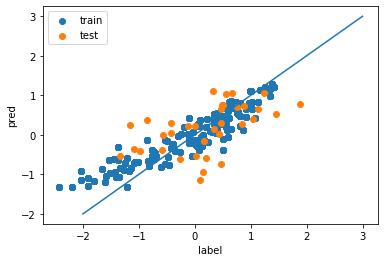

In [10]:
kernel = 'WD_Kernel_Shift'
embedding = 'label'
eva_metric = [mean_squared_error, r2_score]

gpr_train_samples = GPR_Predictor(df, kernel_name = kernel, embedding = embedding, eva_metric = eva_metric,
                   l = 6, s = 1, alpha = 2, eva_on='seqs')
gpr_train_samples.regression()
gpr_train_samples.scatter_plot()

### Projection to first eigenvector

In [32]:
kernel_all = gpr_train_samples.wd_kernel_instance.kernel_all_normalised
first_eign_vector = np.linalg.eigh(kernel_all)[1][-1]
proj = kernel_all.T.dot(first_eign_vector)

pred_all = list(gpr_train_samples.train_df['pred mean'])+  list(gpr_train_samples.test_df['pred mean'])
label_all = list(gpr_train_samples.train_df['AVERAGE'])+  list(gpr_train_samples.test_df['AVERAGE'])

Text(0, 0.5, 'average label')

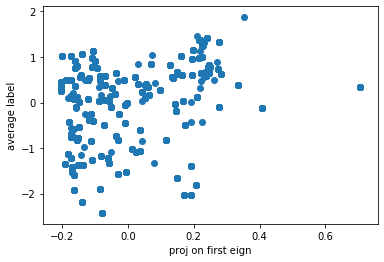

In [33]:
plt.scatter(proj, label_all)
plt.xlabel('proj on first eign')
plt.ylabel('average label')

X train shape:  (845, 80)
X test shape:  (35, 80)
gp_reg fit
gp_reg pred
finish reg
<function mean_squared_error at 0x7f8ffe2c5c80>
Train:  0.17118898180824585
Test:  0.5034507254677599
<function r2_score at 0x7f8ffe2c5ea0>
Train:  0.7940698818585354
Test:  0.11206127548170486


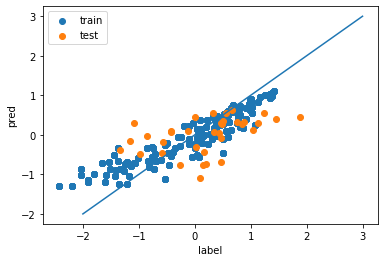

In [7]:
kernel = 'RBF'
embedding = 'onehot'
eva_metric = [mean_squared_error, r2_score]

gpr_train_samples = GPR_Predictor(df, kernel_name = kernel, embedding = embedding, eva_metric = eva_metric,
                   alpha = 2, eva_on='seqs')
gpr_train_samples.regression()
gpr_train_samples.scatter_plot()

In [8]:
gpr_train_samples.gp_reg.kernel_

RBF(length_scale=0.838)